# 1000 Genomes data analysis

## Finding trios

First we need to download the 1000 genomes data; we will use the q-arm of chromosome 20. Trees have already been inferred for this data and are available from [Zenodo](https://zenodo.org/record/5495535):


In [6]:
import urllib.request
#urllib.request.urlretrieve("https://zenodo.org/record/5495535/files/hgdp_tgp_sgdp_chr20_q.dated.trees.tsz?download=1",
#                           "data/hgdp_tgp_sgdp_chr20_q.dated.trees.tsz")

I ran `tsunzip data/hgdp_tgp_sgdp_chr20_q.dated.trees.tsz` to unzip, such that we can load the data


In [7]:
import tskit
import numpy as np
import pandas as pd

ts = tskit.load("data/hgdp_tgp_sgdp_chr20_q.dated.trees")
ts


We need to find a trio and randomly sample three individuals. I have the acession numbers for the trio, so we just need a table with nodes and accession ids

In [8]:
import json

meta = ts.individual(0).metadata
print(json.loads(meta))
print(json.loads(meta)['sample'])
str(meta)

{'array_non_reference_discordance': '0.111741', 'capmq': '29', 'coverage': '29.71', 'freemix': '0.00137', 'insert_size_average': '500.1', 'library': 'HGDP01201.11144852', 'library_type': 'PCR', 'region': 'AFRICA', 'sample': 'HGDP01201', 'sample_accession': 'ERS474141', 'sex': 'F', 'source': 'sanger'}
HGDP01201


'b\'{"array_non_reference_discordance": "0.111741", "capmq": "29", "coverage": "29.71", "freemix": "0.00137", "insert_size_average": "500.1", "library": "HGDP01201.11144852", "library_type": "PCR", "region": "AFRICA", "sample": "HGDP01201", "sample_accession": "ERS474141", "sex": "F", "source": "sanger"}\''

That works fine, but some of the samples don't have accession ids:

In [9]:
meta2 = ts.individual(3752).metadata
print(json.loads(meta2))
print(json.loads(meta)['sample'])

{'aliases': 'zapo0098', 'contributor': 'William Klitz / Cheryl Winkler', 'country': 'Mexico', 'dna_source': 'Genomic_from_cell_lines', 'embargo': 'FullyPublic', 'gender': 'M', 'illumina_id': 'LP6005443-DNA_A12', 'region': 'America', 'sample_id': 'zapo0098', 'sequencing_panel': 'C', 'sgdp_id': 'S_Zapotec-1', 'town': 'San Juan Guelavia'}
HGDP01201


So we need to figure out the metadata structure for this data

In [10]:
ts.table_metadata_schemas

TableMetadataSchemas(node=, edge=, site=, mutation=, migration=, individual=, population=)

That's not helpful. Maybe it would be easier to just do regexp on the raw JSON data. Let's figure it out for one sample

In [11]:
import re
bool(re.search("ERS474141", str(meta)))

True

In [12]:
meta

b'{"array_non_reference_discordance": "0.111741", "capmq": "29", "coverage": "29.71", "freemix": "0.00137", "insert_size_average": "500.1", "library": "HGDP01201.11144852", "library_type": "PCR", "region": "AFRICA", "sample": "HGDP01201", "sample_accession": "ERS474141", "sex": "F", "source": "sanger"}'

In [13]:
print(bool(re.search("HGDP01201|dfsdf", str(meta))))
print(bool(re.search("HGDP01202", str(meta))))

True
False


 We can get the Accession IDs for one trio from [this article](https://wikis.utexas.edu/display/bioiteam/Human+Trios+--+GVA2020). Now let's search

In [14]:
trio_ceu = "NA12892|NA12891|NA12878"

d = []
for i in ts.individuals():
    if bool(re.search(trio_ceu, str(i.metadata))):
        d.append(i.id)
d

[2711]

In [15]:
ts.individual(2711)

Individual(id=2711, flags=0, location=array([], dtype=float64), parents=array([], dtype=int32), nodes=array([5422, 5423], dtype=int32), metadata=b'{"family_id": "1463", "gender": "2", "individual_id": "NA12878", "maternal_id": "NA12892", "other_comments": null, "paternal_id": "NA12891", "phenotype": null, "relationship": "mother; child", "second_order": null, "siblings": null, "third_order": null}')

Well this is peculiar. We only seem to have the proband, not the parents! I found [this list](https://genome.ucsc.edu/cgi-bin/hgTrackUi?db=hg38&g=tgpTrios) of all the trios in 1000 Genomes, so let's check them.

In [16]:
trios_ls = [
    ["NA12892", "NA12891", "NA12878"],
    ["NA19678", "NA19675", "NA19679"],
    ["NA19660", "NA19685", "NA19661"],
    ["HG00732", "HG00733", "HG00731"],
    ["HG00657", "HG00702", "HG00656"],
    ["HG02025", "HG02024", "HG02026"],
    ["NA19238", "NA19240", "NA19239"]
] 

def find_nodes(search_str):
    d = []
    for i in ts.individuals():
        if bool(re.search(search_str, str(i.metadata))):
            d.append(str(i.id))
    return ", ".join(d)


trios_df = pd.DataFrame(trios_ls, columns=["mother","child","father"])
trios_df["search_str"]= trios_df.apply(lambda x: '|'.join(x.values.tolist()), axis=1)
trios_df["search_results"] = trios_df["search_str"].apply(lambda x: find_nodes(x))
trios_df


,mother,child,father,search_str,search_results
0,NA12892,NA12891,NA12878,NA12892|NA12891|NA12878,2711
1,NA19678,NA19675,NA19679,NA19678|NA19675|NA19679,"3150, 3151"
2,NA19660,NA19685,NA19661,NA19660|NA19685|NA19661,"3144, 3146"
3,HG00732,HG00733,HG00731,HG00732|HG00733|HG00731,"1238, 1239"
4,HG00657,HG00702,HG00656,HG00657|HG00702|HG00656,"1214, 1215"
5,HG02025,HG02024,HG02026,HG02025|HG02024|HG02026,"1691, 1692"
6,NA19238,NA19240,NA19239,NA19238|NA19240|NA19239,"3045, 3046"


In [17]:
print(json.loads(ts.individual(3150).metadata))
print(json.loads(ts.individual(3151).metadata))

{'family_id': 'm009', 'gender': '2', 'individual_id': 'NA19678', 'maternal_id': None, 'other_comments': None, 'paternal_id': None, 'phenotype': None, 'relationship': 'mother', 'second_order': 'NA19677', 'siblings': None, 'third_order': None}
{'family_id': 'm009', 'gender': '1', 'individual_id': 'NA19679', 'maternal_id': None, 'other_comments': None, 'paternal_id': None, 'phenotype': None, 'relationship': 'father', 'second_order': 'NA19677', 'siblings': None, 'third_order': None}


So for all the other trios besides the first (which is the CEU trio), only the parents are in the TS, not the child. I'm guessing this we usually exclude related individuals when calculating allele frequencies or conducting a GWAS. It seems like this dataset isn't helpful for our purposes.

## Visualisation experiments

Let's try visualising these trees. To start with, we will work with a simplified tree with 20 nodes from 10 random individuals 

In [18]:
import random
random.seed(2023)
n_individuals = 6

individuals_sample = random.sample(range(ts.num_individuals-1),n_individuals)
ls = []
for m in individuals_sample:
    ls.append(ts.individual(m).nodes)
nodes_sample = np.concatenate(ls)
nodes_sample

array([3136, 3137, 5746, 5747, 3658, 3659, 6912, 6913, 3188, 3189, 2622,
       2623], dtype=int32)

In [19]:
ts_small = ts.simplify(nodes_sample)
ts_small

Let's start by plotting a random subtree

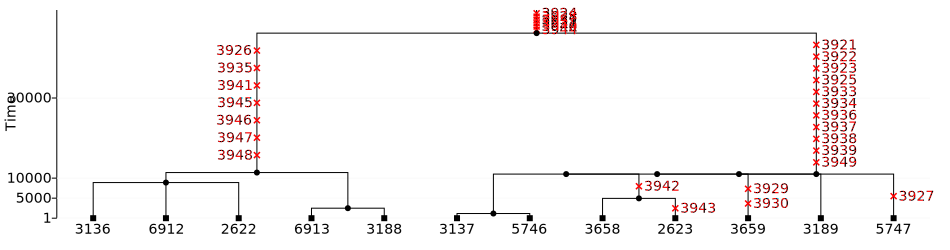

In [20]:
test_ts = ts_small.at_index(200)
wide_fmt = (950, 250)

labels = {}
for n in test_ts.nodes():
    if n in range(20):
        labels[n] = nodes_sample[n]

display(test_ts.draw_svg(
    size=wide_fmt,
    y_gridlines=True,
    y_axis=True,
    y_ticks=[1, 10000, 5000, 30000, 60000],
    node_labels=labels
))

Now let's plot a short sequence of trees in a certain region

In [21]:
ts_small.at_index(202)

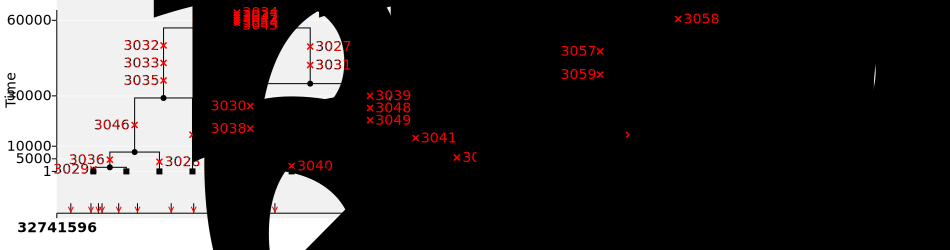

In [22]:
x_limits = [32741596,32749314]

node_label_style = (
    ".node > .lab {font-size: 80%}"
    ".leaf > .lab {text-anchor: start; transform: rotate(90deg) translate(6px)}"
)

ts_small.draw_svg(
    y_gridlines=True,
    size=wide_fmt,
    x_lim=x_limits,
    y_axis=True,
    y_ticks=[1, 10000, 5000, 30000, 60000],
    node_labels=labels,
    style=node_label_style
)

### Closest relative span-wise

#### Testing the code

Using Yan Wong's code [from this issue on GitHub](https://github.com/duncanMR/pedigrees_project/issues/1) we can visualise the average span of the genome in which two samples are in the same subtree. Let's use a trivial example first to understand exactly what it's doing

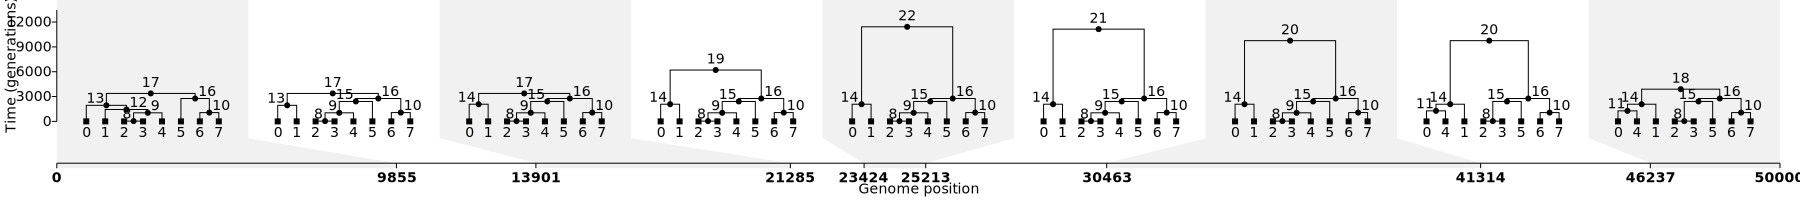

In [23]:
ts2 = tskit.load("data/viz_ts_small.trees")

x_limits = [5000, 15000]
# Create evenly-spaced y tick positions to avoid overlap
y_tick_pos = [0, 3000, 6000, 9000, 12000]

ts2.draw_svg(y_axis=True, y_ticks=y_tick_pos)

In [24]:
sample_span = np.zeros((ts2.num_samples, ts2.num_samples))

for tree in ts2.simplify().trees(sample_lists=True):
    #print(f"Visiting tree {tree.index}")
    if tree.has_single_root:
        for u in ts2.samples():
            #print(f"  Checking neighbours for sample {u} under parent {tree.parent(u)}")
            for nearest in tree.samples(tree.parent(u)):
                if nearest != u:
                    #print(f"    {nearest} is a neighbour of {u}")
                    #print(f"    Adding {tree.span} to the sample span between {u} and {nearest}")
                    sample_span[u, nearest] += tree.span
sample_span = sample_span / ts2.sequence_length
sample_span

array([[0.     , 0.82628, 0.1971 , 0.1971 , 0.37082, 0.     , 0.     ,
        0.     ],
       [0.8029 , 0.     , 0.1971 , 0.1971 , 0.37082, 0.     , 0.     ,
        0.     ],
       [0.     , 0.     , 0.     , 1.     , 0.     , 0.     , 0.     ,
        0.     ],
       [0.     , 0.     , 1.     , 0.     , 0.     , 0.     , 0.     ,
        0.     ],
       [0.17372, 0.     , 0.82628, 0.82628, 0.     , 0.     , 0.     ,
        0.     ],
       [0.     , 0.     , 0.8029 , 0.8029 , 0.62918, 0.     , 0.1971 ,
        0.1971 ],
       [0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
        1.     ],
       [0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 1.     ,
        0.     ]])

In [25]:
n = 3

samples = [str(s) for s in ts2.samples()]
span_df = pd.DataFrame(sample_span.T, columns = samples)
span_df['sample'] = samples
span_melted = span_df.melt(id_vars=['sample'])
span_melted.set_index('sample',drop=True, inplace=True)
topn = span_melted.groupby('variable')['value'].nlargest(n).reset_index()
topn.columns = ['Sample','Neighbour','Value']
topn['Norm_Value'] = topn['Value']/ topn.groupby('Sample')['Value'].transform('sum')
topn = topn.sort_values(['Sample', 'Norm_Value'], ascending=True)
topn


,Sample,Neighbour,Value,Norm_Value
2,0,2,0.19710,0.141371
1,0,4,0.37082,0.265973
0,0,1,0.82628,0.592655
5,1,2,0.19710,0.143783
4,1,4,0.37082,0.270510
3,1,0,0.80290,0.585708
7,2,0,0.00000,0.000000
8,2,1,0.00000,0.000000
6,2,3,1.00000,1.000000
10,3,0,0.00000,0.000000


In [26]:
neighbours = topn['Neighbour'].drop_duplicates().to_list()
neighbours.sort()
neighbours

['0', '1', '2', '3', '4', '6', '7']

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

#ax = sns.histplot(topn, x='Sample', hue='Neighbour', weights='Norm_Value',
#                  multiple='stack', shrink=0.8, hue_order = neighbours, palette="Paired")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set(xlabel='Sample', ylabel='Proportion of span')

plt.show()

NameError: name 'ax' is not defined

Now let's write this as a general function

In [ ]:

def make_span_df(ts, n_per_sample):
    sample_span = np.zeros((ts.num_samples, ts.num_samples))

    for tree in ts.simplify().trees(sample_lists=True):
        if tree.has_single_root:
            for u in ts.samples():
                for nearest in tree.samples(tree.parent(u)):
                    if nearest != u:
                        sample_span[u, nearest] += tree.span
    sample_span = sample_span / ts.sequence_length
    samples = [str(s) for s in ts.samples()]
    
    #Construct the dataframe
    span_df = pd.DataFrame(sample_span.T, columns = samples)
    span_df['sample'] = samples
    
    #Melt the dataframe for plotting
    span_melted = span_df.melt(id_vars=['sample'])
    span_melted.set_index('sample',drop=True, inplace=True)
    topn = span_melted.groupby('variable')['value'].nlargest(n_per_sample).reset_index()
    topn.columns = ['Sample','Neighbour','Value']
    #Normalise spans so that the bars are of the same height
    topn['Norm_Value'] = topn['Value']/ topn.groupby('Sample')['Value'].transform('sum')
    topn.sort_values(by='Sample', inplace=True, key=lambda x : x.astype(int))
    return topn

def plot_span_df(df, palette, normaliseQ = False):
    #neighbours_list ordered for plotting
    neighbours = df['Neighbour'].drop_duplicates().to_list()
    neighbours.sort(key = int)
    
    #using histplot because it can create stacked bar charts nicely
    if normaliseQ:
        ax = sns.histplot(df, x='Sample', hue='Neighbour', weights='Norm_Value',
                      multiple='stack', shrink=0.8, hue_order = neighbours, palette=palette)
    else:
        ax = sns.histplot(df, x='Sample', hue='Neighbour', weights='Value',
                      multiple='stack', shrink=0.8, hue_order = neighbours, palette=palette)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    ax.set(xlabel='Sample', ylabel='Span')

    plt.show()
    

#### Applying code to real data

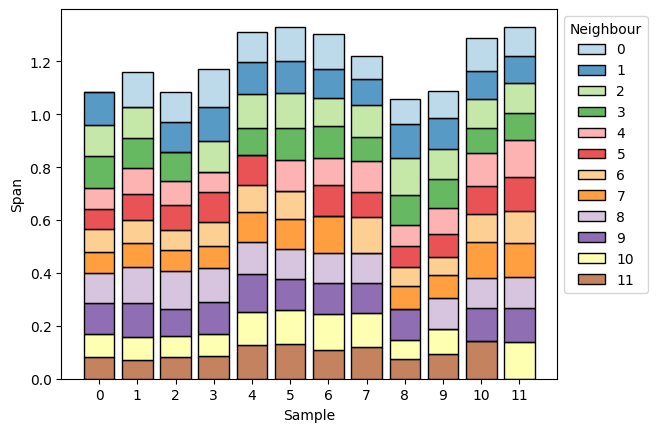

In [ ]:
span_df = make_span_df(ts_small, 12)
plot_span_df(span_df, "Paired")


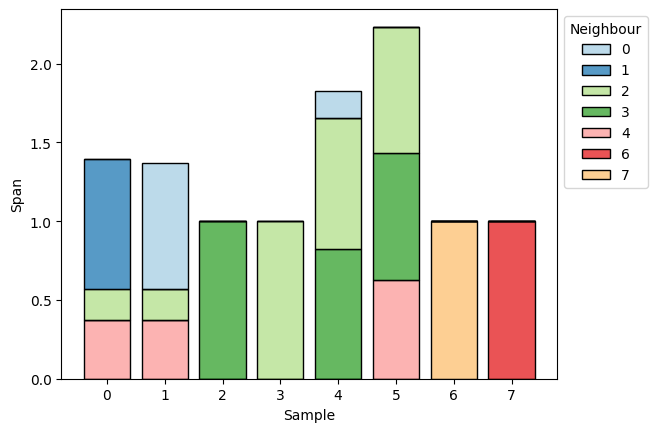

In [ ]:
span_df = make_span_df(ts2, 3)
plot_span_df(span_df, "Paired")

Since the individuals are presumably unrelated, no sample is particularly close to any other sample for a large span of the genome.

### Topological methods

If a pair of samples are closely related, we expect that subtrees including the pair will tend to have them clustered together with a shared parent. We can assess this by counting how many topologies there are across the genome in which the pair share a parent. Let's use our example from before, starting with just a single tree

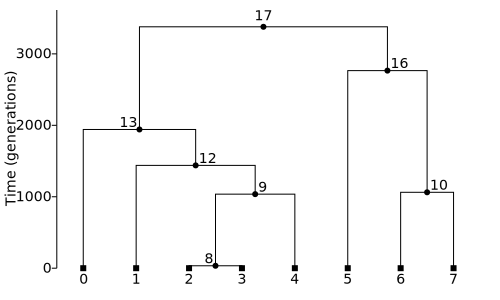

In [ ]:
ts2.first().draw_svg(y_axis=True, y_ticks=[0,1000,2000,3000], size=(500,300))

Let's see how many tree topologies have 0 and 1 together. First we need to construct the sample lists

In [ ]:
sample1 = [2]
sample2 = [4]
other_samples = list(set(range(ts2.num_samples))-set(sample1)-set(sample2))
other_samples

[0, 1, 3, 5, 6, 7]

Now we can use the `count_topologies` method. Since the [documentation for this function is limited](https://tskit.dev/tskit/docs/stable/python-api.html#tskit.Tree.count_topologies), we need to examine its methods to figure out how to extract our data

In [ ]:
tc = ts2.first().count_topologies(sample_sets=[sample1 ,sample2, other_samples])
dir(tc)[-1:-5:-1]


['topologies', 'merge', 'from_sample', '_to_key']

In [ ]:
topologies = tc.topologies
topologies[0,1,2]

Counter({Rank(shape=1, label=2): 5, Rank(shape=1, label=1): 1})

We only want the topologies with all 3 sample nodes included, so we drop the others

Rank(shape=1, label=2); Count: 5


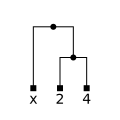

Rank(shape=1, label=1); Count: 1


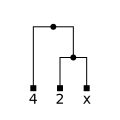

In [ ]:
for rank, count in topologies[0,1,2].items():
    print(f"{rank}; Count: {count}")
    t = tskit.Tree.unrank(num_leaves=3, rank=rank)
    display((t.draw_svg(node_labels={0: sample1[0], 1: sample2[0], 2: "x"}, order="tree", size=(120, 120))))

### Generalising to multiple trees

First we need to make a general function to compute sample sets for counting topologies

In [ ]:
def make_sample_sets(ts, sample_list):
    ### Given a list of samples of interest, e.g. a trio, generate a list of 
    ### all other samples in the ts and output the results in a list format
    ### for the topology.counter method
    
    other_samples = list(set(range(ts.num_samples))-set(sample_list))
    samples_sets = [[s] for s in sample_list]
    samples_sets.append(other_samples)
    return samples_sets

In [ ]:
sample_sets = make_sample_sets(ts2, [0,3])
sample_sets

[[0], [3], [1, 2, 4, 5, 6, 7]]

We want to store the count of each possible topology for each tree in the sequence. Let's initialise an array and take it from there

In [ ]:
sample_list = [0,1]

ranks = [ts.rank() for ts in tskit.all_trees(num_leaves = len(sample_list)+1)]
ranks

[Rank(shape=0, label=0),
 Rank(shape=1, label=0),
 Rank(shape=1, label=1),
 Rank(shape=1, label=2)]

In [ ]:
counts_df = pd.DataFrame(np.zeros((ts2.num_trees, len(ranks))), columns=ranks).astype(int)


In [ ]:
all_nodes = tuple(range(len(sample_list)+1))
all_nodes

(0, 1, 2)

In [ ]:
for tree, tc in enumerate(ts2.count_topologies(sample_sets=sample_sets)):
    for rank, count in tc.topologies[all_nodes].items():
    #   print(f"{rank}; Count: {count}")
        counts_df[rank][tree] = count
        
counts_df

,"(0, 0)","(1, 0)","(1, 1)","(1, 2)"
0,0,3,0,3
1,0,5,1,0
2,0,5,1,0
3,0,5,1,0
4,0,5,1,0
5,0,5,1,0
6,0,5,1,0
7,0,4,2,0
8,0,4,2,0


So we can generate a dataframe with rows being the tree index and columns the counts for each possible topology. Let's wrap this in a function

In [ ]:
def count_topologies(ts, sample_list):
    ### Loop through the trees in the ts, recording the count of every
    ### possible topology in each tree into a dataframe
    
    sample_sets = make_sample_sets(ts, sample_list)
    all_ranks = [ts.rank() for ts in tskit.all_trees(num_leaves = len(sample_list)+1)]
    all_nodes = tuple(range(len(sample_list)+1)) #to extract topologies including all nodes
    counts_df = pd.DataFrame(np.zeros((ts.num_trees, len(all_ranks))), columns=all_ranks).astype(int)
    
    for tree, tc in enumerate(ts.count_topologies(sample_sets=sample_sets)):
        for rank, count in tc.topologies[all_nodes].items():
            counts_df[rank][tree] = count
    
    counts_df['LeftInterval'] = [t.interval[0] for t in ts.trees()]
    counts_df['RightInterval'] = [t.interval[1] for t in ts.trees()]
    counts_df['Width'] = counts_df['RightInterval'] - counts_df['LeftInterval']
    #counts_df['TreeIndex'] = range(ts.num_samples+1)
    return counts_df


In [ ]:
n = 3
excl_columns = ['LeftInterval','RightInterval','Width']
counts_df = count_topologies(ts2, [0,3])
counts = counts_df.drop(excl_columns, axis=1)
counts_df

,"(0, 0)","(1, 0)","(1, 1)","(1, 2)",LeftInterval,RightInterval,Width
0,0,3,0,3,0.0,9855.0,9855.0
1,0,5,1,0,9855.0,13901.0,4046.0
2,0,5,1,0,13901.0,21285.0,7384.0
3,0,5,1,0,21285.0,23424.0,2139.0
4,0,5,1,0,23424.0,25213.0,1789.0
5,0,5,1,0,25213.0,30463.0,5250.0
6,0,5,1,0,30463.0,41314.0,10851.0
7,0,4,2,0,41314.0,46237.0,4923.0
8,0,4,2,0,46237.0,50000.0,3763.0


In [ ]:
totals = counts.sum(axis=0).reset_index()
totals.columns = ["Rank", "Count"]
totals.sort_values(by="Count", ascending=False, inplace=True)
topn_totals = totals.head(n)
topn_counts = counts[topn_totals['Rank']]
topn_counts

,"(1, 0)","(1, 1)","(1, 2)"
0,3,0,3
1,5,1,0
2,5,1,0
3,5,1,0
4,5,1,0
5,5,1,0
6,5,1,0
7,4,2,0
8,4,2,0


I think a stacked bar chart would work best here. Let's choose a colorscheme first

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import rgb2hex

# Create a colormap object with the "Set1" colormap
cmap = ListedColormap(plt.get_cmap('tab10').colors)

# Get the first 3 color values from the colormap
colors = cmap.colors[:3]

# Convert the RGB color values to hexadecimal color values
hex_colors = [rgb2hex(color) for color in colors]

# Print the list of hexadecimal color values
print(hex_colors)

['#1f77b4', '#ff7f0e', '#2ca02c']


In [28]:
topn_counts.plot(kind='bar', stacked=True, color=hex_colors)

NameError: name 'topn_counts' is not defined

Let's make the bars variable width. We will use the stackplot function; first we need to prepare the data. For some reason, if there are n samples then stackplot needs n+1 points on the x axis; however, it still requires n+1 height values for the n stacks. Hence, we add a dummy row to the heights which is never plotted.

In [ ]:
x = counts_df['LeftInterval'].to_numpy()
rightmost = counts_df['RightInterval'].to_list()[-1]
x = np.append(x, rightmost)

heights = topn_counts.astype(int).to_numpy()
last = [heights[-1]]
heights = np.vstack([heights, last])
x

array([    0.,  9855., 13901., 21285., 23424., 25213., 30463., 41314.,
       46237., 50000.])

NameError: name 'x' is not defined

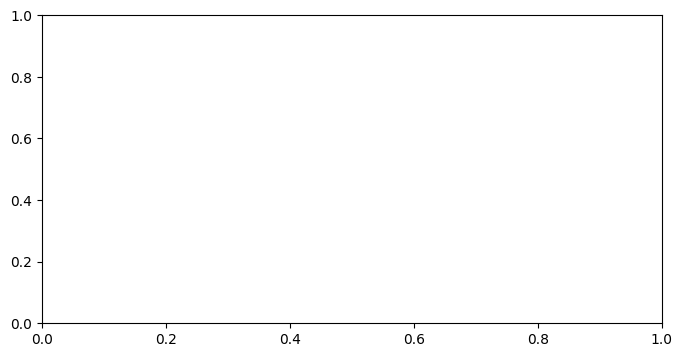

In [29]:
import matplotlib.pyplot as plt
import numpy as np

plot_path = 'results/rank_dist.svg'

# Create the stacked bar chart using stackplot
fig, ax = plt.subplots(figsize=(8, 4))
ax.stackplot(x/1000, heights.T, step='post', colors=hex_colors)

# Set the y-axis label and limit
ax.set_ylabel('Count')
ax.set_xlabel('Genomic position (kBP)')

# Show the plot
plt.savefig(plot_path)
plt.show()

Now let's make a nice legend with the topologies visualised

In [ ]:
topn_totals

,Rank,Count
1,"(1, 0)",41
2,"(1, 1)",10
3,"(1, 2)",3


In [30]:
sample_list=[0,3]
import cairosvg
from IPython.display import SVG, display

def make_css(colors, index):
    return (f".edge {{stroke: {colors[index]}; stroke-width: 2px}}"
            ".node {font-size: 16px, margin-top: 20px, padding-top: 20px}")

for index, row in topn_totals.iterrows():
    style_str = make_css(hex_colors, index-1)
    rank_str = f"Rank: ({row['Rank'].shape}, {row['Rank'].label}); Count: {row['Count']}"  
    
    t = tskit.Tree.unrank(num_leaves=3, rank=row['Rank'])
    svg = t.draw_svg(node_labels={0: sample_list[0], 1: sample_list[1], 2: "x"}, 
                     order="tree", size=(200, 120), style=style_str, x_axis=False)

    # Add centered heading above the tree plot
    svg = f'<svg width="200" height="160" xmlns="http://www.w3.org/2000/svg">{svg}'
    svg += f'<text x="100" y="20" text-anchor="middle" font-size="16">{rank_str}</text>'
    svg += '</svg>'
    
    png = cairosvg.svg2png(bytestring=svg.encode('utf-8'), background_color='#ffffff')
    with open(f"results/test{index-1}.png", "wb") as f:
        f.write(png)
    

NameError: name 'topn_totals' is not defined

In [ ]:
from PIL import Image, ImageOps
padding = 10

# Open the PIL image and the three PNG images
pil_image = Image.open('dist.png')
# Trim the bordering whitespace of the PIL image
png_image_1 = Image.open('results/test0.png')
png_image_2 = Image.open('results/test1.png')
png_image_3 = Image.open('results/test2.png')

# Calculate the desired width and height of the final image
width = max(pil_image.width, png_image_1.width * 3)
height = pil_image.height + png_image_1.height + padding*3

# Expand the PNG images to the desired size and with white border
expanded_png_1 = ImageOps.expand(png_image_1, border=padding, fill=(255, 255, 255))
expanded_png_2 = ImageOps.expand(png_image_2, border=padding, fill=(255, 255, 255))
expanded_png_3 = ImageOps.expand(png_image_3, border=padding, fill=(255, 255, 255))

# Create a new white image with the desired dimensions
new_image = Image.new('RGB', (width, height), (255, 255, 255))

# Paste the PIL image onto the top of the new image
new_image.paste(pil_image, (0, 0))

# Paste the three PNG images onto the bottom of the new image
x_offset = (width - (png_image_1.width + png_image_2.width + png_image_3.width + 2 * padding)) // 2
y_offset = pil_image.height + padding
new_image.paste(expanded_png_1, (x_offset, y_offset))
new_image.paste(expanded_png_2, (x_offset + png_image_1.width + padding, y_offset))
new_image.paste(expanded_png_3, (x_offset + png_image_1.width + png_image_2.width + 2 * padding, y_offset))

# Save the final image
new_image.save('final.png')

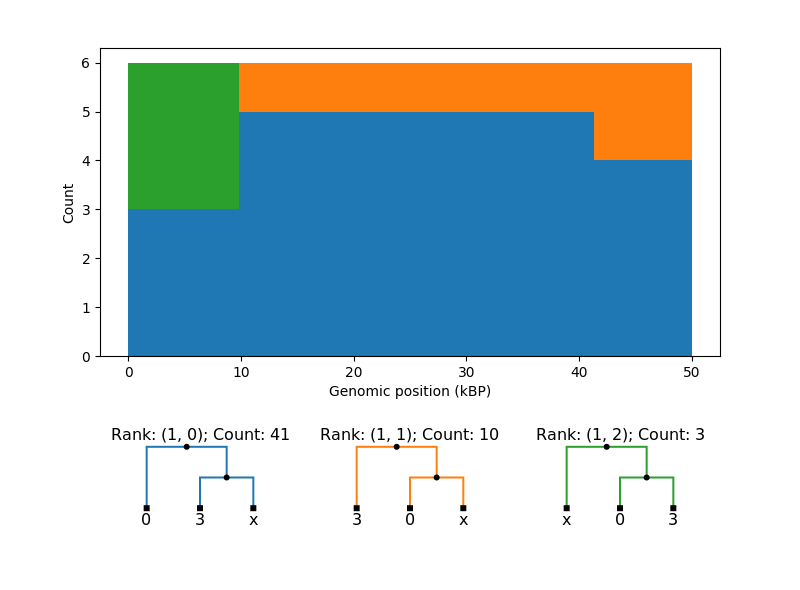

In [48]:
from IPython.display import Image
Image(filename='final.png') 

## Consolidating functions

### Topologies and stackplot

In [31]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import rgb2hex

def make_sample_sets(ts, sample_list):
    ### Given a list of samples of interest, e.g. a trio, generate a list of 
    ### all other samples in the ts and output the results in a list format
    ### for the topology.counter method
    
    other_samples = list(set(range(ts.num_samples))-set(sample_list))
    samples_sets = [[s] for s in sample_list]
    samples_sets.append(other_samples)
    return samples_sets

def count_topologies(ts, sample_list):
    ### Loop through the trees in the ts, recording the count of every
    ### possible topology in each tree into a dataframe
    
    sample_sets = make_sample_sets(ts, sample_list)
    all_ranks = [ts.rank() for ts in tskit.all_trees(num_leaves = len(sample_list)+1)]
    all_nodes = tuple(range(len(sample_list)+1)) #to extract topologies including all nodes
    counts_df = pd.DataFrame(np.zeros((ts.num_trees, len(all_ranks))), columns=all_ranks).astype(int)
    
    for tree, tc in enumerate(ts.count_topologies(sample_sets=sample_sets)):
        for rank, count in tc.topologies[all_nodes].items():
            counts_df[rank][tree] = count
    
    counts_df['LeftInterval'] = [t.interval[0] for t in ts.trees()]
    counts_df['RightInterval'] = [t.interval[1] for t in ts.trees()]
    counts_df['Width'] = counts_df['RightInterval'] - counts_df['LeftInterval']
    #counts_df['TreeIndex'] = range(ts.num_samples+1)
    return counts_df

def get_colors(n, colormap):
    ### Return a list of n hex colors from a given matplotlib colormap
    ### (https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html)
    
    cmap = ListedColormap(plt.get_cmap(colormap).colors)
    colors = cmap.colors[:n]
    hex_colors = [rgb2hex(color) for color in colors]
    
    return hex_colors

def plot_counts(counts_df, sample_list, plot_path, n=3, color_map='tab10', 
                fig_width_inches=8, dpi=300):
    ### Plot the top n most common topologies in the ts
    ### and return the total counts of each topology with
    ### associated colors for tree legend plot
    
    excl_columns = ['LeftInterval','RightInterval','Width'] #we just want the counts
    counts = counts_df.drop(excl_columns, axis=1)
    totals = counts.sum(axis=0).reset_index() #count across all trees
    totals.columns = ["Rank", "Count"]
    totals.sort_values(by="Count", ascending=False, inplace=True)
    topn_totals = totals.head(n) #get the top n most common topologies
    topn_counts = counts[topn_totals['Rank']]


    x = counts_df['LeftInterval'].to_numpy()
    rightmost = counts_df['RightInterval'].to_list()[-1]
    x = np.append(x, rightmost)

    # For some reason, if there are n samples then stackplot needs n+1 points on the x axis;
    #  however, it still requires n+1 height values for the n stacks. 
    # Hence, we add a dummy row to the heights which is never plotted.
    heights = topn_counts.astype(int).to_numpy()
    last = [heights[-1]]
    heights = np.vstack([heights, last])
    
    # Create the stacked bar chart using stackplot
    hex_colors = get_colors(n, color_map)
    fig, ax = plt.subplots()
    ax.stackplot(x/1000, heights.T, step='post', colors=hex_colors)

    # Set the y-axis label and limit
    ax.set_ylabel('Count')
    ax.set_xlabel('Genomic position (kBP)')
    fig.set_size_inches(fig_width_inches, fig_width_inches/1.618)
    fig.set_dpi(dpi)

    # Save the plot and show it
    plt.savefig(plot_path, dpi=dpi, bbox_inches='tight')
    plt.show()
    #Return the top n most common topologies and their counts for further analysis
    return topn_totals, hex_colors


### Tree plots and combined image

In [49]:
sample_list = [0,3]

def make_node_labels(sample_list, sample_labels='None')
    ### Given a list of samples of interest, e.g. a trio, generate a dictionary
    ### of node labels for each sample based on sample_labels. Add a last entry
    ### to the dictionary for x, which represents other samples not in the sample list
    ### If sample_labels is not provided, use the sample_list as the labels.

    if sample_labels == 'None':
        sample_labels = sample_list
    node_labels = {sample: sample_labels[index] for index, sample in enumerate(sample_list)}
    node_labels[len()

    




for index, sample in enumerate(sample_list):
    sample_list[index] = sample + 1

[0, 1, 2]

In [44]:
import cairosvg
from IPython.display import SVG, display

def make_css(colors, index):
    ### Return a string of CSS to color the edges of the tree plot
    return (f".edge {{stroke: {colors[index]}; stroke-width: 2px}}"
            ".node {font-size: 16px, margin-top: 20px, padding-top: 20px}")


def plot_topn_trees(topn_totals, hex_colors, sample_list, img_path_prefix="results/tree", n=3, colormap='tab10'):
    ### Plot the top n most common topologies in the ts with edge colors
    ### corresponding to the colors in the stacked bar chart

    for index, row in topn_totals.iterrows():
        style_str = make_css(hex_colors, index-1)
        rank_str = f"Rank: ({row['Rank'].shape}, {row['Rank'].label}); Count: {row['Count']}"  
        
        t = tskit.Tree.unrank(num_leaves=len(sample_list), rank=row['Rank'])
        svg = t.draw_svg(node_labels={0: sample_list[0], 1: sample_list[1], 2: "x"}, 
                        order="tree", size=(200, 120), style=style_str, x_axis=False)

        # Add centered heading above the tree plot
        svg = f'<svg width="200" height="160" xmlns="http://www.w3.org/2000/svg">{svg}'
        svg += f'<text x="100" y="20" text-anchor="middle" font-size="16">{rank_str}</text>'
        svg += '</svg>'
        
        png = cairosvg.svg2png(bytestring=svg.encode('utf-8'), background_color='#ffffff')
        with open(f"{img_path_prefix}{index-1}.png", "wb") as f:
            f.write(png)


from PIL import Image, ImageOps
padding = 10

# Open the PIL image and the three PNG images
pil_image = Image.open('dist.png')
# Trim the bordering whitespace of the PIL image
png_image_1 = Image.open('results/test0.png')
png_image_2 = Image.open('results/test1.png')
png_image_3 = Image.open('results/test2.png')

# Calculate the desired width and height of the final image
width = max(pil_image.width, png_image_1.width * 3)
height = pil_image.height + png_image_1.height + padding*3

# Expand the PNG images to the desired size and with white border
expanded_png_1 = ImageOps.expand(png_image_1, border=padding, fill=(255, 255, 255))
expanded_png_2 = ImageOps.expand(png_image_2, border=padding, fill=(255, 255, 255))
expanded_png_3 = ImageOps.expand(png_image_3, border=padding, fill=(255, 255, 255))

# Create a new white image with the desired dimensions
new_image = Image.new('RGB', (width, height), (255, 255, 255))

# Paste the PIL image onto the top of the new image
new_image.paste(pil_image, (0, 0))

# Paste the three PNG images onto the bottom of the new image
x_offset = (width - (png_image_1.width + png_image_2.width + png_image_3.width + 2 * padding)) // 2
y_offset = pil_image.height + padding
new_image.paste(expanded_png_1, (x_offset, y_offset))
new_image.paste(expanded_png_2, (x_offset + png_image_1.width + padding, y_offset))
new_image.paste(expanded_png_3, (x_offset + png_image_1.width + png_image_2.width + 2 * padding, y_offset))

# Save the final image
new_image.save('final.png')

In [38]:
import numpy as np
import msprime

ts3 = msprime.sim_ancestry(10, sequence_length=1e5, recombination_rate=1e-4, random_seed=1)


In [34]:
ts3

In [46]:
topn_totals

'Rank'

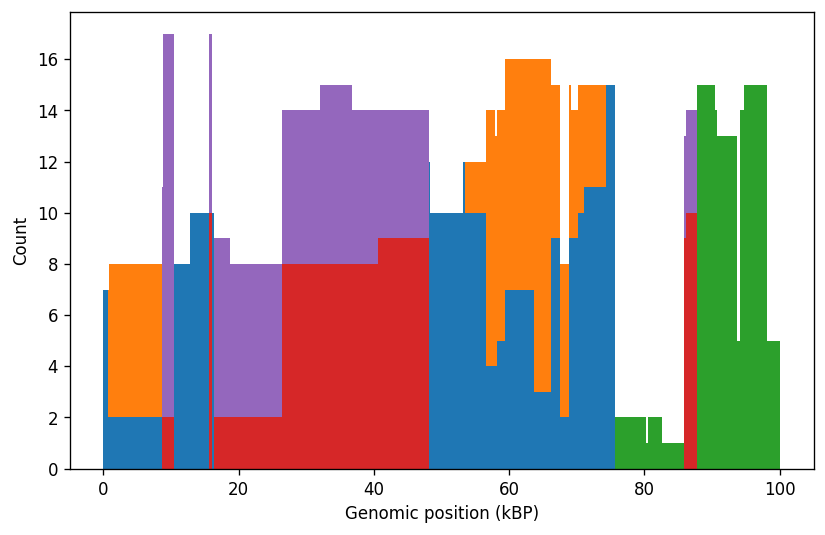

AttributeError: 'str' object has no attribute 'iterrows'

In [45]:
sample_list = [0,1,2]
counts_df = count_topologies(ts3, sample_list)
topn_totals, hex_colors = plot_counts(counts_df, sample_list, "results/test.png", n=5, dpi=120)
plot_topn_trees(topn_totals, hex_colors, sample_list, img_path_prefix="results/tree", n=5, colormap='tab10')


def get_index_from_pedigree_id(pedigree_id, df) :
    # Return the platekey of the participant with the given pedigree_id
    # or NaN if there is no such participant
    try:
        return df.loc[df['rare_diseases_pedigree_id'] == pedigree_id].index[0]
    except IndexError:
        return -1
def add_parent_indices(df):
    # Add two columns, mother_id and father_id, to the dataframe and add platekeys for each parent
    # if they exist
    df['mother_index'] = df['mother_id'].apply(lambda x: get_index_from_pedigree_id(x,df))
    df['father_index'] = df['father_id'].apply(lambda x: get_index_from_pedigree_id(x,df))
    return df